In [1]:
import numpy as np
import scipy as sp

In [2]:
from matplotlib import pyplot as plt
import skimage
from skimage import (morphology, segmentation, exposure, feature, filters,
                     measure, transform, util, io, color)

In [3]:
from toolz.curried import *

In [4]:
from spotz import imgz, gridder2, segmenter2, spotzplot

In [5]:
from importlib import reload

In [6]:
reload(imgz)
reload(gridder2)
reload(spotzplot)
reload(segmenter2)

<module 'segmenter2' from '/Users/pmagwene/gits/spotz/segmenter2.py'>

In [7]:
%matplotlib inline

# User settings

In [8]:
# change name of file
PLATE_IMG = "test2-384.tif"
OUTPUT_FILE = "test_output.csv"

# change number of rows and cols as appropriate
NROWS = 16
NCOLS = 24

# change if you'd like larger or smaller figs
FIG_SIZE = (10,8)

# Original image

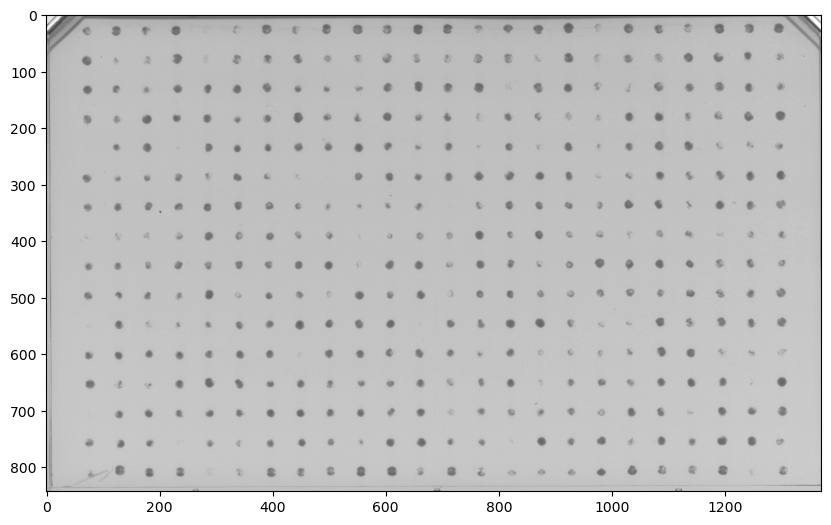

In [12]:
img = imgz.read_image(PLATE_IMG)

imgz.imshowg(img, figsize = FIG_SIZE)
pass

# Invert image

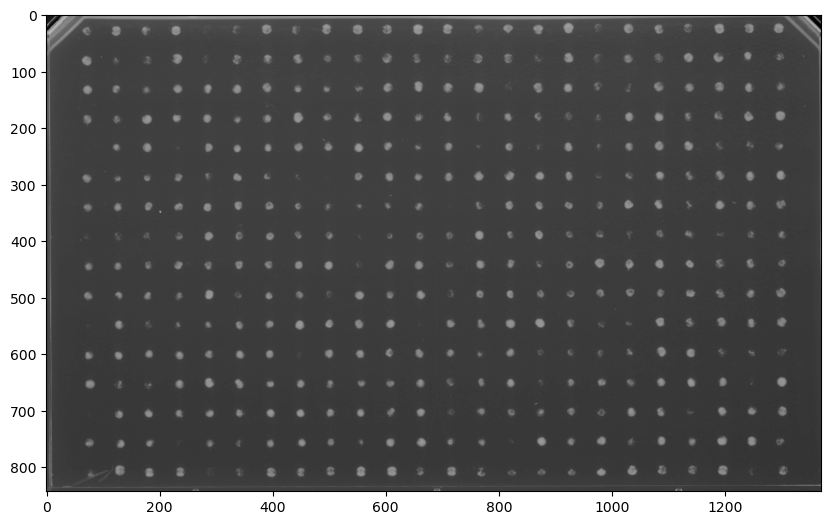

In [13]:
iimg = imgz.invert(img)

imgz.imshowg(iimg, figsize = FIG_SIZE)
pass

# Gridding

## Thresholding and binary opening

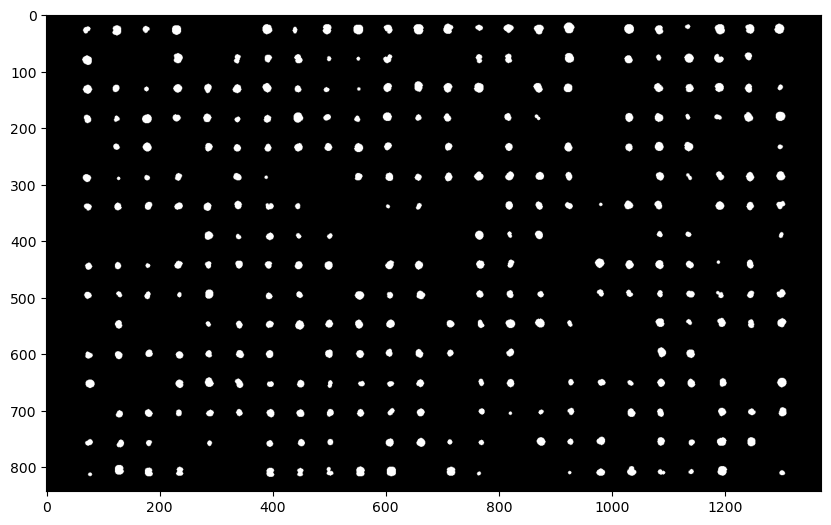

In [22]:
# initial thresholding and rotation correction
rbimg = pipe(iimg, 
             imgz.threshold_otsu,
             imgz.disk_opening(3), 
             imgz.clear_border,
             gridder2.fix_rotation)

imgz.imshowg(rbimg, figsize = FIG_SIZE)
pass

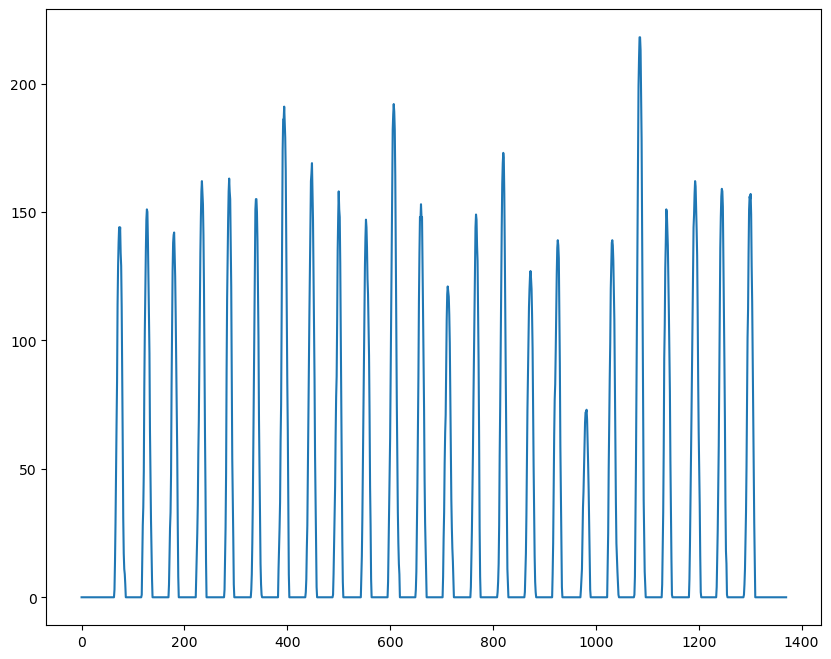

In [49]:
import peakutils
nr,nc = rbimg.shape
rowsums = np.sum(rbimg, axis=0)
colsums = np.sum(rbimg, axis=1)
plt.figure(figsize=FIG_SIZE)
plt.plot(rowsums)
#imgz.imshowg(rbimg)
#plt.plot(colsums, colsums-843)
# rowpks = peakutils.indexes(rowsums, min_dist=30)
# colpks = peakutils.indexes(colsums, min_dist=30)
# plt.vlines(x=rowpks, ymin=0, ymax=nr, color='red')
# plt.hlines(y=colpks, xmin=0, xmax=nc, color='red')
# plt.xlim(0, nc)
# plt.ylim(0, nr)

## Estimate grid coordinates and draw grid

In [16]:
g = gridder2.find_grid(NROWS, NCOLS, rbimg)

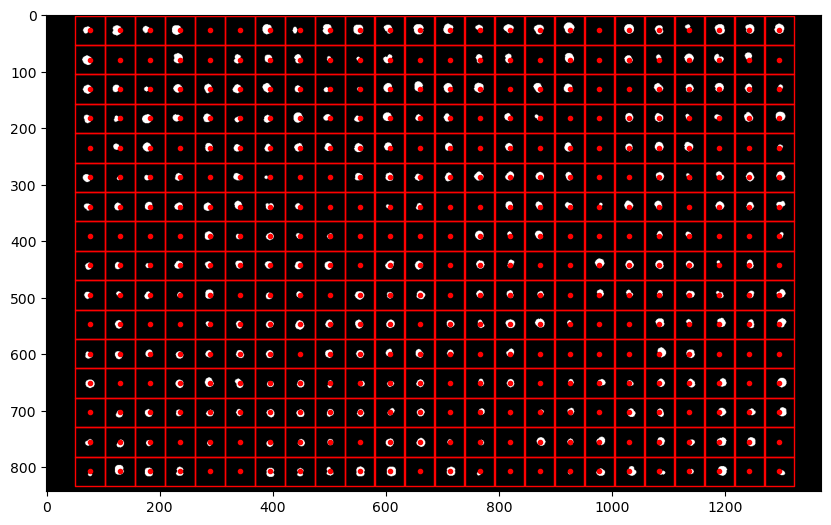

In [17]:
imgz.imshowg(rbimg, figsize = FIG_SIZE)
ax = plt.gca()
ax.plot(g.centers[:,1], g.centers[:,0], 'r.')
spotzplot.draw_bboxes(g.bboxes, ax)
pass

# Segmentation

## Rethreshold based on grid

In [ ]:
timg = pipe(iimg,
            segmenter2.threshold_bboxes(g.bboxes, min_local_threshold=0.8),
            imgz.remove_small_objects(50),
            imgz.remove_small_holes(25),
            imgz.disk_closing(1),
            imgz.clear_border)

fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(timg)
pass

## Segmentation by watershed

### Filter objects by grid

In [ ]:
filtered_img, filtered_regions = segmenter2.assign_objects_to_grid(g.centers, 
                                                                   timg, 
                                                                   maxdist = 30) 
filtered_bboxes = [r.bbox if r else None for r in filtered_regions]



In [ ]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(filtered_img > 0)
pass

In [ ]:
wshed = segmenter2.watershed_segment_bboxes(g.centers, 
                                             filtered_bboxes, 
                                             iimg, timg, 
                                             seed_width = 5)

In [ ]:
fig = plt.figure(figsize = FIG_SIZE)
ax = plt.gca()
ax.imshow(color.label2rgb(wshed, img, bg_label = 0))
pass

In [ ]:
fig, ax = spotzplot.draw_image_and_labels(img, wshed,
                                          mask_cmap = "Reds", alpha = 0.35,
                                         fontsize = 10, textcolor = "orange")
fig.set_size_inches(FIG_SIZE)

In [ ]:
import spotstats

In [ ]:
regions = measure.regionprops(wshed, intensity_image = filtered_img)

In [ ]:
colonydf = spotstats.colony_stats(regions, 16, 24)
colonydf

In [ ]:
colonydf.to_csv(OUTPUT_FILE, index=False)
print("file saved as", OUTPUT_FILE)